# 4.6 暂退法（Dropout）
:label:`sec_dropout`

在 "weight_decay权重衰减" 中，
我们介绍了通过惩罚权重的$L_2$范数来正则化统计模型的经典方法。
在概率角度看，我们可以通过以下论证来证明这一技术的合理性：
我们已经假设了一个先验，即权重的值取自均值为0的高斯分布。
更直观的是，<span style="color:#6B8CBE;font-weight:600;font-size:16px">我们希望模型深度挖掘特征，即将其权重分散到许多特征中，
而不是过于依赖少数潜在的虚假关联。</span>

## 4.6.1重新审视过拟合

当面对更多的特征而样本不足时，线性模型往往会过拟合。
相反，当给出更多样本而不是特征，通常线性模型不会过拟合。
不幸的是，线性模型泛化的可靠性是有代价的。
简单地说，<span style="color:#6B8CBE;font-weight:600;font-size:16px">线性模型没有考虑到特征之间的交互作用,因此不易过拟合</span>
对于每个特征，线性模型必须指定正的或负的权重，而忽略其他特征。

泛化性和灵活性之间的这种基本权衡被描述为**偏差-方差权衡**（bias-variance tradeoff）。
线性模型有很高的偏差：它们只能表示一小类函数。
然而，这些模型的方差很低：它们在不同的随机数据样本上可以得出相似的结果。

----
深度神经网络位于偏差-方差谱的另一端。
与线性模型不同，神经网络并不局限于单独查看每个特征，而是学习特征之间的交互。
例如，神经网络可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，
但单独出现则不表示垃圾邮件。

即使我们有比特征多得多的样本，深度神经网络也有可能过拟合。
2017年，一组研究人员通过在随机标记的图像上训练深度网络。
这展示了神经网络的极大灵活性，因为人类很难将输入和随机标记的输出联系起来，
但通过随机梯度下降优化的神经网络可以完美地标记训练集中的每一幅图像。
想一想这意味着什么？
假设标签是随机均匀分配的，并且有10个类别，那么分类器在测试数据上很难取得高于10%的精度，
那么这里的泛化差距就高达90%，如此严重的过拟合。

<span style="color:#6B8CBE;font-weight:600;font-size:16px">
    - 深度神经网络可以很好地学到特征之间的关系;<br>
    - 随机梯度下降可以对随便标记的样本进行学习,甚至完美学习.
</span>

深度网络的泛化性质令人费解，而这种泛化性质的数学基础仍然是悬而未决的研究问题。
我们鼓励喜好研究理论的读者更深入地研究这个主题。  
*本节，我们将着重对实际工具的探究，这些工具倾向于改进深层网络的泛化性。*

## 4.6.2 扰动的稳健性

在探究泛化性之前，我们先来定义一下什么是一个“好”的预测模型？
我们期待“好”的预测模型能在未知的数据上有很好的表现：
经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。
简单性以较小维度的形式展现，
我们在 :numref:`sec_model_selection` 讨论线性模型的单项式函数时探讨了这一点。
此外，正如我们在 :numref:`sec_weight_decay` 中讨论权重衰减（$L_2$正则化）时看到的那样，
参数的范数也代表了一种有用的简单性度量。

简单性的另一个角度是平滑性，即函数不应该对其输入的微小变化敏感。
例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。
1995年，克里斯托弗·毕晓普证明了
具有输入噪声的训练等价于Tikhonov正则化 :cite:`Bishop.1995`。
这项工作用数学证实了“要求函数光滑”和“要求函数对输入的随机噪声具有适应性”之间的联系。
<span style="color:#6B8CBE;font-weight:600;font-size:16px">
    "好"的模型=简单=<br>
    1.维度较低-->参数少/权重衰减($L_2$正则化)<br>
    2.平滑-->对噪声不敏感-->训练时人为加入噪声应该没有影响
</span>

然后在2014年，斯里瓦斯塔瓦等人 :cite:`Srivastava.Hinton.Krizhevsky.ea.2014`
就如何将毕晓普的想法应用于网络的内部层提出了一个想法：
<span style="color:#6B8CBE;font-weight:600;">在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。
因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。</span>

这个想法被称为**暂退法（dropout）**。
暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。
这种方法之所以被称为*暂退法*，因为我们<span style="color:#6B8CBE;font-weight:600;">从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。</span>

*需要说明的是，暂退法的原始论文提到了一个关于有性繁殖的类比：
神经网络过拟合与每一层都依赖于前一层激活值相关，称这种情况为 **“共适应性”**。
作者认为，暂退法会破坏共适应性，就像有性生殖会破坏共适应的基因一样。*

----

那么关键的挑战就是如何注入这种噪声。
一种想法是以一种**无偏向**（unbiased）的方式注入噪声。
这样在固定住其他层时，每一层的期望值等于没有噪音时的值。


在毕晓普的工作中，他将高斯噪声添加到线性模型的输入中。
在每次训练迭代中，他将从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$
采样噪声添加到输入$\mathbf{x}$，
从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$，
预期是<span style="color:#6B8CBE;font-weight:600;font-size:16px">$E[\mathbf{x}'] = \mathbf{x}$。
</span>
在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。
换言之，每个中间活性值$h$以*暂退概率*$p$由随机变量$h'$替换，如下所示：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况 },1-p
\end{cases}
\end{aligned}
$$

根据此模型的设计，其期望值保持不变，即$E[h'] = h$。

<span style="color:#6B8CBE;font-weight:600;font-size:16px">总共为1,有 $p$ 个神经元被置0,则剩下 $p-1$ 个仍为 $h$ ,然后除以 $\frac{1}{1-p}$ 实现规范化</span>

<div style="background: #c6e6e8; border-left: 5px solid #22a2c3; padding: 10px; margin: 10px 0;">
<strong>THINK</strong><br>
这里就很像之前学过的降维
</div>

## 4.6.3 实践中的暂退法

回想一下 :下图中带有1个隐藏层和5个隐藏单元的多层感知机。
当我们将暂退法应用到隐藏层，以$p$的概率将隐藏单元置为零时，
结果可以看作一个只包含原始神经元子集的网络。
比如在下图中，删除了$h_2$和$h_5$，
因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。
这样，输出层的计算不能过度依赖于$h_1, \ldots, h_5$的任何一个元素。

![dropout前后的多层感知机](../img/dropout2.svg)


通常，我们在测试时不用暂退法。
给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。
然而也有一些例外：一些研究人员在测试时使用暂退法，
用于估计神经网络预测的“不确定性”：
如果通过许多不同的暂退法遮盖后得到的预测结果都是一致的，那么我们可以说网络发挥更稳定。

<span style="color:#6B8CBE;font-weight:600;font-size:16px">测试时通常不使用暂退,除非特殊目的</span>

## 4.6.4 从零开始实现

要实现单层的暂退法函数，
我们从均匀分布$U[0, 1]$中抽取样本<span style="color:#6B8CBE;font-weight:600;font-size:16px">(torch.rand--均匀分布[0, 1) )</span>，样本数与这层神经网络的维度一致。
然后我们保留那些对应样本大于$p$的节点，把剩下的丢弃。

在下面的代码中，(**我们实现 `dropout_layer` 函数，
该函数以`dropout`的概率丢弃张量输入`X`中的元素**)，
如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。

In [46]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

我们可以通过下面几个例子来[**测试`dropout_layer`函数**]。
我们将输入`X`通过暂退法操作，暂退概率分别为0、0.5和1。


In [47]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.6))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.0000,  2.5000,  0.0000,  7.5000,  0.0000, 12.5000,  0.0000, 17.5000],
        [ 0.0000,  0.0000,  0.0000, 27.5000, 30.0000, 32.5000,  0.0000,  0.0000]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 定义模型参数

同样，我们使用 3.5节fashion_mnist中引入的Fashion-MNIST数据集。
我们[**定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元**]。


In [48]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 定义模型

我们可以将暂退法应用于每个隐藏层的输出（在激活函数之后），
并且可以为每一层分别设置暂退概率：
常见的技巧是在靠近输入层的地方设置较低的暂退概率。
下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5，
并且暂退法只在训练期间有效。


In [67]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))  #把展平层写在了一起
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


### [**训练和测试**]

这类似于前面描述的多层感知机训练和测试。


In [58]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,log=False,file=None):  #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    if log and file:
        with open(file,'a') as flog:  #log很有用很方便
            flog.write(f'{net}\n\
            num_epochs:{num_epochs} batch_size:{batch_size} lr:{lr}\n')
            flog.write(f'train_loss:{train_loss:.6f} train_acc:{train_acc:.6f} test_acc: {test_acc:.6f}\n\n')
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

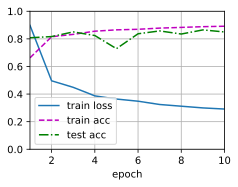

In [60]:
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 10, 0.5, 256
file="./log/dropout.log"
log=True
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer,log=log,file=file)

<span style="color:#6B8CBE;font-weight:600;font-size:16px">
    - 经过尝试,使用暂退法的确可以一定程度上缓解过拟合<br>
    <br>
    - 那么如果是去掉每一层中过小的值呢?----经过试验,好像不行,至少好像不能简单地去掉<br>
    - <del>后面再试试,感觉可以优化一下.或者说增加轮数?</del><br>
    - 标准暂退法正则化通过以概率 $p$ 随机丢弃实现扰动,重点在于等概率丢弃<br><br>
    - 后面学习到更多/思考到降维时再看看
</span>


<br>[试验见 dropout-small](./dropout-small.ipynb)

## 4.6.5 简洁实现

对于深度学习框架的高级API，我们只需在每个全连接层之后添加一个`Dropout`层，
将暂退概率作为唯一的参数传递给它的构造函数。
在训练时，`Dropout`层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。
在测试时，`Dropout`层仅传递数据。


In [74]:
dropout1, dropout2 = 0.2, 0.7
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

接下来，我们[**对模型进行训练和测试**]。


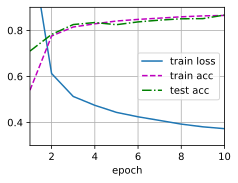

In [75]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 小结

* 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
* 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用的。
* 暂退法将活性值$h$替换为具有期望值$h$的随机变量。
* 暂退法仅在训练期间使用。

## 练习

[Discussions](https://discuss.d2l.ai/t/1813)


### 1. 如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？

设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

In [87]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,log=False,file=None):  #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    if log and file:
        with open(file,'a') as flog:  #log很有用很方便
            flog.write(f'dropout1: {net[3].p}  dropout2: {net[6].p}\n\
            num_epochs:{num_epochs} batch_size:{batch_size} lr:{lr}\n')
            flog.write(f'train_loss:{train_loss:.6f} train_acc:{train_acc:.6f} test_acc: {test_acc:.6f}\n\n')
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [94]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

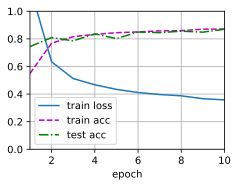

In [102]:
dropout1, dropout2 = 0.1, 0.7
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

file='./log/dropout_practice.log'
log=True
net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer,log,file)

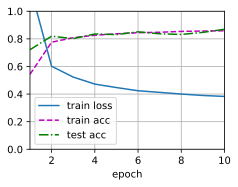

In [100]:
dropout1, dropout2 = 0.5, 0.3
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

file='./log/dropout_practice.log'
log=True
net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer,log,file)

<span style="color:#eb261a;font-weight:600;font-size:16px">ANSWER:</span>
**在保持两层dropout概率总和相同时,每一次具体是多少对最终结果影响不大**  
尝试了(0.3,0.5),(0.2,0.6),(0.1,0.7),(0.5,0.3)  
这应该也可以根据数学知识推出

### 2. 增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

In [107]:
num_epochs=30

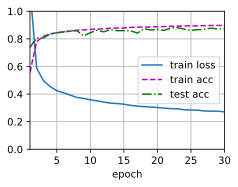

In [108]:
dropout1, dropout2 = 0.3, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

file='./log/dropout_practice.log'
log=True
net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer,log,file)

In [120]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,log=False,file=None):  #@save
    """训练模型（定义见第3章）"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    if log and file:
        with open(file,'a') as flog:  #log很有用很方便
            flog.write(f'{net}\n')
            if isinstance(net[3],nn.Dropout) and isinstance(net[6],nn.Dropout):
                flog.write(f'dropout1: {net[3].p}  dropout2: {net[6].p}\n')
            flog.write(f'num_epochs:{num_epochs} batch_size:{batch_size} lr:{lr}\n')
            flog.write(f'train_loss:{train_loss:.6f} train_acc:{train_acc:.6f} test_acc: {test_acc:.6f}\n\n')
    
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

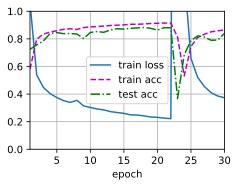

In [121]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),

        nn.Linear(256, 256),
        nn.ReLU(),

        nn.Linear(256, 10))

file='./log/dropout_practice.log'
log=True
net.apply(init_weights);
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer,log,file)


1. 当应用或不应用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。
1. 为什么在测试时通常不使用暂退法？
1. 以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？
1. 如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？
1. 发明另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。